# Homework 4 Question 3: Spline fitting.
We are running a series of experiments to evaluate the properties of a new fluorescent material. As we vary the intensity of the incident light, the material should fluoresce different amounts. Unfortunately, the material isn’t perfectly uniform and our method for measuring fluorescence is not very accurate. After testing 200 different intensities, we obtained the result below (also available in xy_data.csv). The intensities $x_i$ and fluorescences $y_i$ are recorded in the first and second columns of the data matrix, respectively.

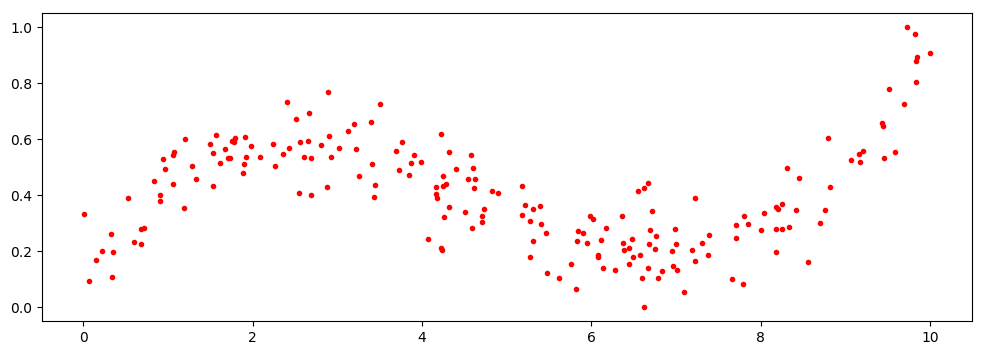

In [2]:
# Load the data file
raw = readcsv("xy_data.csv")
x = raw[:,1]
y = raw[:,2]

using PyPlot
figure(figsize=(12,4))
plot(x,y,"r.");

The material has interesting nonlinear properties, and we would like to characterize the relationship
between intensity and fluorescence by using an approximate model that agrees well with the trend of
our experimental data. Although there is noise in the data, we know from physics that the fluorescence
must be zero when the intensity is zero. This fact must be reflected in all of our models!


__a) Polynomial fit. Find the best cubic polynomial fit to the data. In other words, look for a
function of the form__
$ y = a_1x^3 + a_2x^2 + a_3x + a_4$
__that has the best possible agreement with the
data. Remember that the model should have zero fluorescence when the intensity is zero! Include
a plot of the data along with your best-fit cubic on the same axes.__

In [3]:
# order of polynomial to use
k = 3

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k
        A[i,j] = x[i]^(k+1-j)
    end
end

In [4]:
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
status = solve(m)
uopt = getvalue(u)
println(status)
println("Error: ",getobjectivevalue(m),", Parameters learnt: ", uopt)

Optimal
Error: 1.8806614807652764, Parameters learnt: [0.00932501,-0.134546,0.511155,0.0]


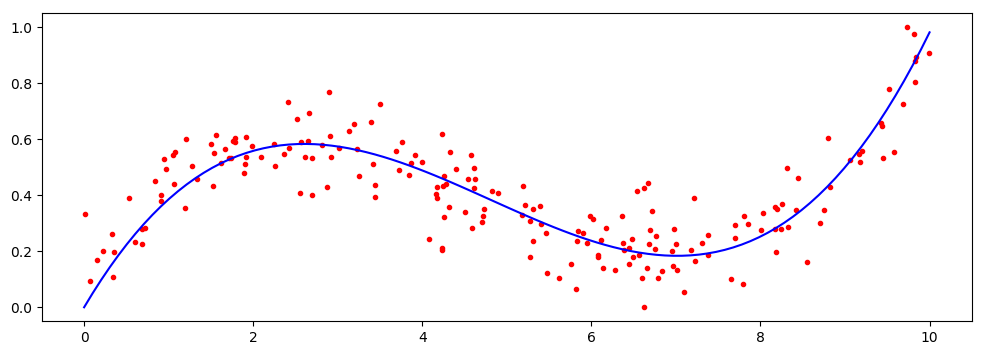

In [5]:
npts = 100
xfine = linspace(0,10,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(12,4))
plot( x, y, "r.")
plot( xfine, yfine, "b-");

__b) Spline fit. Instead of using a single cubic polynomial, we will look for a fit to the data using two
quadratic polynomials. Specifically, we want to find coefficients pi and qi so that our data is well
modeled by the piecewise quadratic function:__

$$y = \begin{cases} 
      p_1x^2 + p_2x + p_3  & 0 \leq x < 4 \\
      q_1x^2 + q_2x + q_3  & 4 \leq x < 10 \\
   \end{cases}$$


__These quadratic functions must be designed so that:__
- __as in the cubic model, there is zero fluorescence when the intensity is zero.__
- __both quadratic pieces have the same value at x = 4.__
- __both quadratic pieces have the same slope at x = 4.__

__In other words, we are looking for a smooth piecewise quadratic. This is also known as a spline
(this is just one type of spline, there are many other types!). Include a plot of the data along with
your best-fit model.__

In [9]:
# order of polynomial to use
k1 = 2
k2 = 2
k = (k1+1) + (k2+1)
# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k)
for i = 1:n
    if x[i] >= 0 && x[i] < 4
        for j = 1:k1
            A[i,j] = x[i]^(k1+1-j)
        end
        for j = k1+2:k
            A[i,j] = 0
        end
    else
        for j = 1:k1+1
            A[i,j] = 0
        end
        for j = k1+2:k
            A[i,j] = x[i]^(2(k1+1)-j)
        end
    end
end

In [41]:
m = Model(solver=GurobiSolver(OutputFlag=0))

inflection = 4.0
value_p = [inflection^2 ;inflection; 0]
value_q = [inflection^2 ;inflection; 1]
derivative_p = [2inflection; 1; 0]
derivative_q = [2inflection; 1; 0]

@variable(m, u[1:k])
@constraint(m, value, sum(value_p'*u[1:3]) == sum(value_q'*u[4:6]))
@constraint(m, derivative, sum(derivative_p'*u[1:3]) == sum(derivative_q'*u[4:6]))
@objective(m, Min, sum( (y - A*u).^2 ) )
status = solve(m)
uopt = getvalue(u)
println(status)
println("Error: ",getobjectivevalue(m))
println("Parameters learnt:p[1:3] ", uopt[1:3])
println("Parameters learnt:q[1:3] ", uopt[4:6] )

Optimal
Error: 2.05841510845039
Parameters learnt:p[1:3] [-0.0873261,0.467682,0.0]
Parameters learnt:q[1:3] [0.0484683,-0.618673,2.17271]


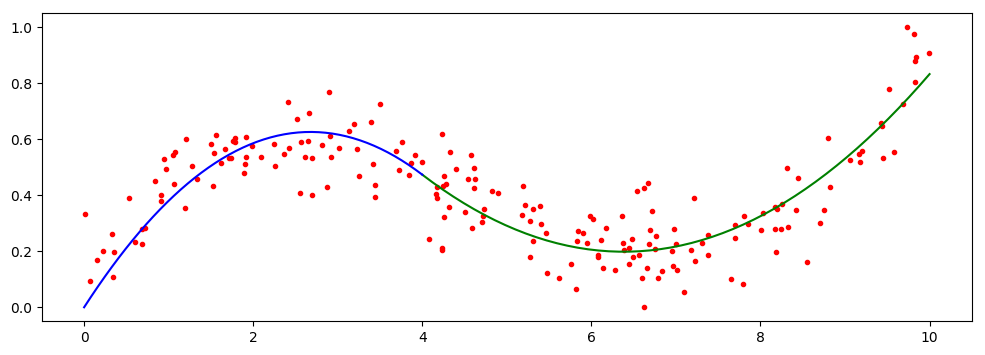

In [42]:
npts = 50
xfineL = linspace(0,4,npts)
ffineL = ones(npts)
for j = 1:k1
    ffineL = [ffineL.*xfineL ones(npts)]
end
yfineL = ffineL * uopt[1:k1+1]

xfineR = linspace(4,10,npts)
ffineR = ones(npts)
for j = 1:k2
    ffineR = [ffineR.*xfineR ones(npts)]
end
yfineR = ffineR * uopt[k1+2:k]

figure(figsize=(12,4))
plot( x, y, "r.")
plot( xfineR, yfineR, "g-")
plot( xfineL, yfineL, "b-");